In [8]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr
import math as math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn')

C:\Users\pkoll\AppData\Local\Temp\ipykernel_980\1272907536.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [9]:
dsm  = xr.open_dataset('eqcross_mv05iv06_r01_mti_2021.nc')
dsi  = xr.open_dataset('eqcross_mv05iv06_r01_ivm_2021 (1).nc')

dsi = dsi.load()

In [10]:
dsm

<xarray.Dataset>
Dimensions:    (num: 7594, dt: 33, alt: 84)
Coordinates:
  * alt        (alt) float64 88.38 91.33 94.28 97.21 ... 297.7 300.0 302.3 304.6
  * dt         (dt) float64 -480.0 -450.0 -420.0 -390.0 ... 420.0 450.0 480.0
  * num        (num) int64 0 1 2 3 4 5 6 ... 7587 7588 7589 7590 7591 7592 7593
Data variables: (12/35)
    u          (num, dt, alt) float64 ...
    v          (num, dt, alt) float64 ...
    lon        (num, dt) float64 ...
    lat        (num, dt) float64 ...
    u_error    (num, dt, alt) float64 ...
    v_error    (num, dt, alt) float64 ...
    ...         ...
    Ue1P       (num) float64 ...
    Ue2P       (num) float64 ...
    Ue1H_err   (num) float64 ...
    Ue2H_err   (num) float64 ...
    Ue1P_err   (num) float64 ...
    Ue2P_err   (num) float64 ...

### Loading in Data

In [4]:
#CWW
dm0_CCW = dsm[['u','v', 'Ue1H','Ue1P']].sel(dt=slice(-45,45)).mean(dim= 'dt').isel(alt=slice(2,-2)) # Only u, v, Hall variables
di0_CCW = dsi[['drift_mer','slt','dm_flag', 'rpa_flag']].sel(dt=slice(-45,45)).mean(dim = 'dt')# only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)
dt0 = dsi[['time']]

d_CCW = xr.merge((dm0_CCW, di0_CCW, dt0))
d_CCW = d_CCW.dropna(dim='num', how='any', subset=['u','drift_mer','Ue1H','Ue1P']) # Drop missing data

# Only keep data where the ivm quality flag is good
d_CCW = d_CCW.where((d_CCW.slt > 11) & (d_CCW.slt < 16) & (d_CCW.dm_flag == 0) & (d_CCW.rpa_flag == 0), drop=True)

In [5]:
#PCA
dm0_PCA = dsm[['u','v', 'q']].sel(dt=0).isel(alt=slice(2,-2)) # Only u, v variables, but also quality (q) variable for possible later filtering
di0_PCA = dsi[['drift_mer','slt', 'time', 'dm_flag', 'rpa_flag']].sel(dt=0) # only use drift_mer variable (but also save other variables for context: local time, actual time, IVM data quality flags)

d_PCA = xr.merge((dm0_PCA, di0_PCA))
d_PCA = d_PCA.dropna(dim='num', how='any', subset=['u','drift_mer']) # Drop missing data

# Only keep later LTs and data where the ivm quality flag is good
d_PCA = d_PCA.where((d_PCA.slt > 11) & (d_PCA.slt < 16) & (d_PCA.dm_flag == 0) & (d_PCA.rpa_flag == 0), drop=True)


In [6]:
#Technically, both d_PCA and d_CCW should be the same thing (hopefully), so i'm proceeding as though they are and will
#come back here if that fails. Fingers crossed.

d = d_CCW

### PAIRS

In [7]:
# This will save all of the changes between the pairs.
delta_u = [] 
delta_drift_mer = []
delta_uh = []
delta_up = []

for i in range(len(d.num)):
    # Status indicator
    if np.mod(i,50) == 0:
        print('%i / %i' % (i, len(d.num)))
    
    ds1 = d.isel(num=i)
    
    # Grab all other timestamps that are 24-24.15 hours in the future, collect them in dataset ds2
    delta_t = d.time - ds1.time 
    happens_soon_after = (delta_t > pd.to_timedelta('24h')) & (delta_t < pd.to_timedelta('24.15h'))
    ds2 = d.where(happens_soon_after, drop=True)
        
    # Record some parameters of interest.
    delta_u.extend(ds2.u - ds1.u)
    delta_drift_mer.extend(ds2.drift_mer - ds1.drift_mer)
    delta_uh.extend(ds2.Ue1H - ds1.Ue1H)
    delta_up.extend(ds2.Ue1P - ds1.Ue1P)
    

delta_u = np.array(delta_u)
delta_drift_mer = np.array(delta_drift_mer)
delta_uh = np.array(delta_uh)
delta_up = np.array(delta_up)

0 / 1533
50 / 1533
100 / 1533
150 / 1533
200 / 1533
250 / 1533
300 / 1533
350 / 1533
400 / 1533
450 / 1533
500 / 1533
550 / 1533
600 / 1533
650 / 1533
700 / 1533
750 / 1533
800 / 1533
850 / 1533
900 / 1533
950 / 1533
1000 / 1533
1050 / 1533
1100 / 1533
1150 / 1533
1200 / 1533
1250 / 1533
1300 / 1533
1350 / 1533
1400 / 1533
1450 / 1533
1500 / 1533


In [11]:
df_u = pd.DataFrame(delta_u[:,:,0])
df_drift_mer = pd.DataFrame(delta_drift_mer[:,0])
df_hall = pd.DataFrame(delta_uh[:,0])
df_peterson = pd.DataFrame(delta_up[:,0])

### Training

In [12]:
#CCW
df_CCW = pd.DataFrame()
df_CCW['Hall'] = df_hall[0]
df_CCW['Peterson'] = df_peterson[0]
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X_CCW = df_CCW
X_CCW.columns = X_CCW.columns.astype(str)
y_CCW = df_drift_mer

#Train Test Split
X_train_CCW, X_test_CCW, y_train_CCW, y_test_CCW = train_test_split(X_CCW, y_CCW, test_size=0.30, random_state=42)

sc = StandardScaler()
sc.fit(X_train_CCW)
sc.fit(X_test_CCW)

X_reduced_train_CCW = sc.transform(X_train_CCW)
X_reduced_test_CCW = sc.transform(X_test_CCW)


CCW_model = LinearRegression(fit_intercept=True)
CCW_model.fit(X_reduced_train_CCW, y_train_CCW)

d_hp = dsm[['ue1h_coef','ue1p_coef']].mean(dim = 'num').isel(alt=slice(2,-2))# Only Hall,Peterson variables
weight_CCW = d_hp.to_array()
d_HP= pd.DataFrame(weight_CCW)

SP_CCW = d_HP.T.dot(CCW_model.coef_[0])

In [17]:
#PCA
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_PCA = df_u
y_PCA = df_drift_mer


#Train Test Split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.30)

sc = StandardScaler()
sc.fit(X_train_PCA)
sc.fit(X_test_PCA)

X_reduced_train = sc.transform(X_train_PCA)
X_reduced_test = sc.transform(X_test_PCA)


pca = PCA(n_components = 8)
pca.fit(X_reduced_train)

X_train_pca = pca.transform(X_reduced_train)
X_test_pca = pca.transform(X_reduced_test)

model_PCA = LinearRegression(fit_intercept=True)
model_PCA.fit(X_train_pca, y_train_PCA)

SP_PCA = pca.components_.T.dot(model_PCA.coef_[0])


<IPython.core.display.Javascript object>


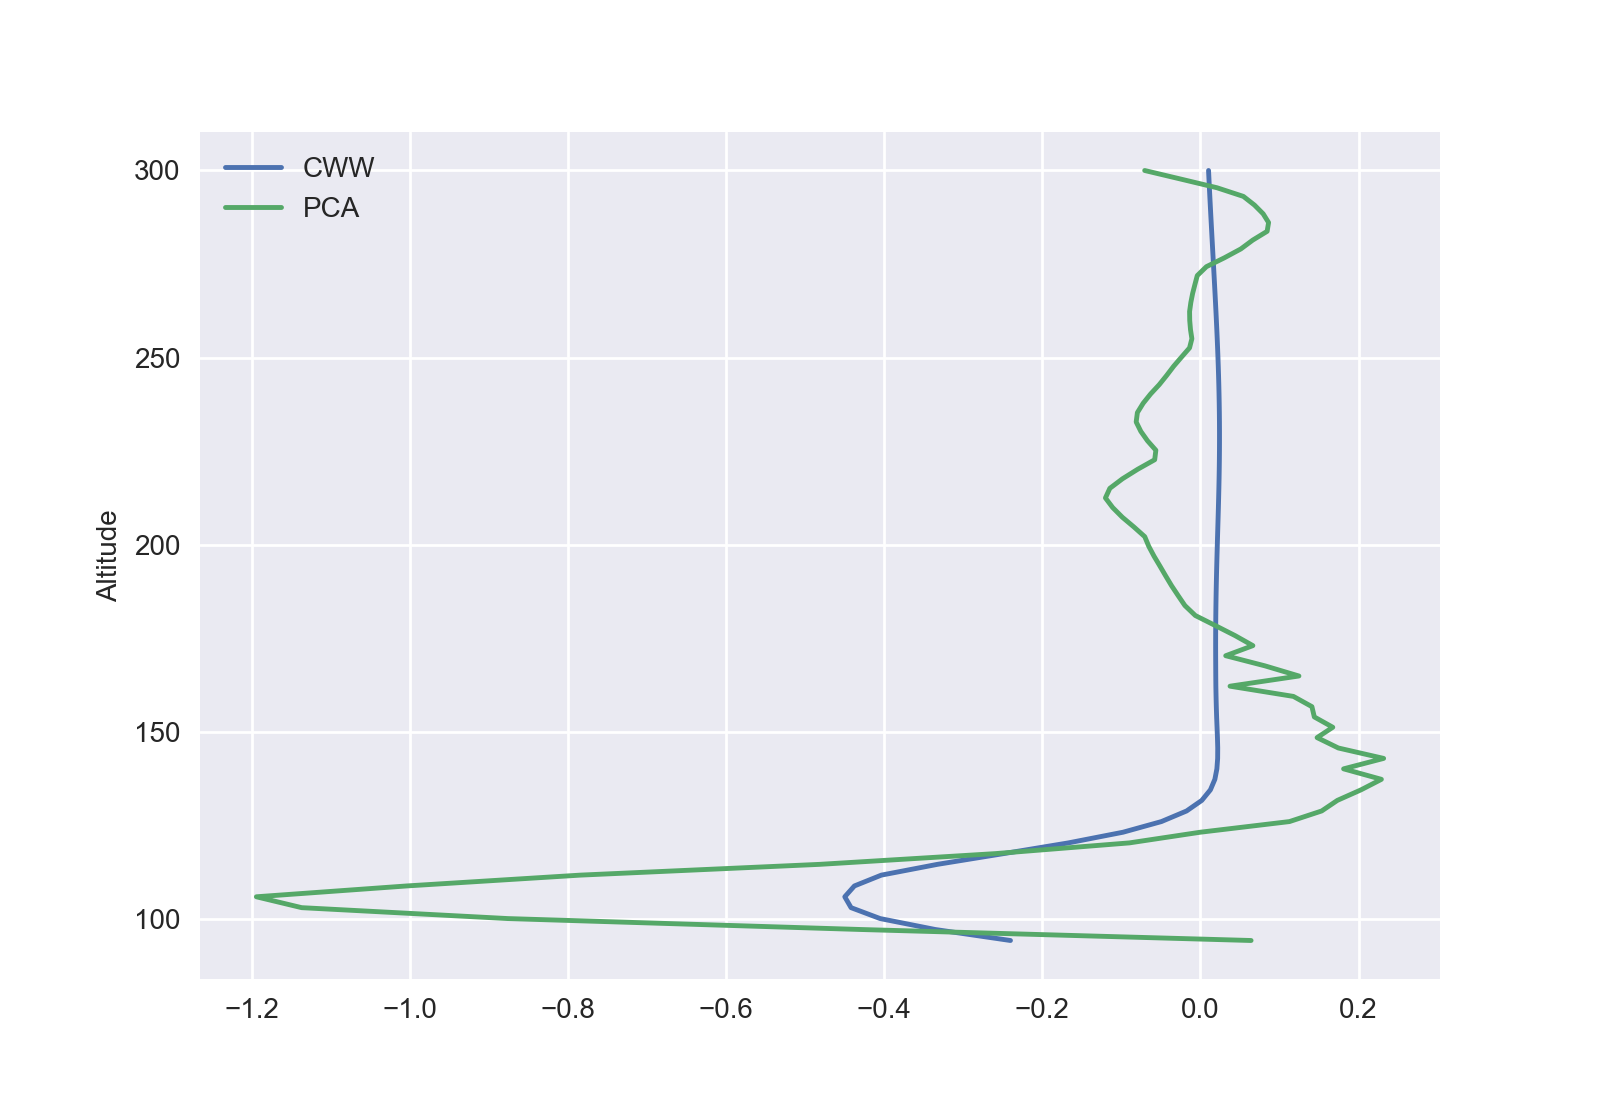

In [18]:
plt.figure()
plt.plot(SP_CCW,d.alt, label = 'CWW')
plt.plot(SP_PCA,d.alt, label = 'PCA')

plt.ylabel('Altitude')
plt.legend()
plt.show()

## NO SCALING

In [11]:
#CCW
df_CCW = pd.DataFrame()
df_CCW['Hall'] = df_hall[0]
df_CCW['Peterson'] = df_peterson[0]
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X_CCW = df_CCW
X_CCW.columns = X_CCW.columns.astype(str)
y_CCW = df_drift_mer

#Train Test Split
X_train_CCW, X_test_CCW, y_train_CCW, y_test_CCW = train_test_split(X_CCW, y_CCW, test_size=0.30, random_state=42)

CCW_model = LinearRegression(fit_intercept=True)
CCW_model.fit(X_train_CCW, y_train_CCW)

d_hp = dsm[['ue1h_coef','ue1p_coef']].mean(dim = 'num').isel(alt=slice(2,-2))# Only Hall,Peterson variables
weight_CCW = d_hp.to_array()
d_HP= pd.DataFrame(weight_CCW)

y_train_pred_CCW = CCW_model.predict(X_train_CCW)
y_test_pred_CCW = CCW_model.predict(X_test_CCW)

from sklearn.metrics import r2_score
r2_train_sk_CCW = r2_score(y_train_CCW, y_train_pred_CCW)
r2_test_sk_CCW = r2_score(y_test_CCW, y_test_pred_CCW)

SP_CCW = d_HP.T.dot(CCW_model.coef_[0])
print(r2_train_sk_CCW,r2_test_sk_CCW)

0.2011338237745236 0.2601003477879873


In [12]:
#PCA
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_PCA = df_u
y_PCA = df_drift_mer


#Train Test Split
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA, y_PCA, test_size=0.30, random_state=42)

pca = PCA(n_components = 8)
pca.fit(X_train_PCA)

X_train_pca = pca.transform(X_train_PCA)
X_test_pca = pca.transform(X_test_PCA)

model_PCA = LinearRegression(fit_intercept=True)
model_PCA.fit(X_train_pca, y_train_PCA)

SP_PCA = pca.components_.T.dot(model_PCA.coef_[0])


y_train_pred_PCA = model_PCA.predict(X_train_pca)
y_test_pred_PCA = model_PCA.predict(X_test_pca)

from sklearn.metrics import r2_score
r2_train_sk_PCA = r2_score(y_train_PCA, y_train_pred_PCA)
r2_test_sk_PCA = r2_score(y_test_PCA, y_test_pred_PCA)
print(r2_train_sk_PCA,r2_test_sk_PCA)

0.25195927408674423 0.27674470517995464


<IPython.core.display.Javascript object>


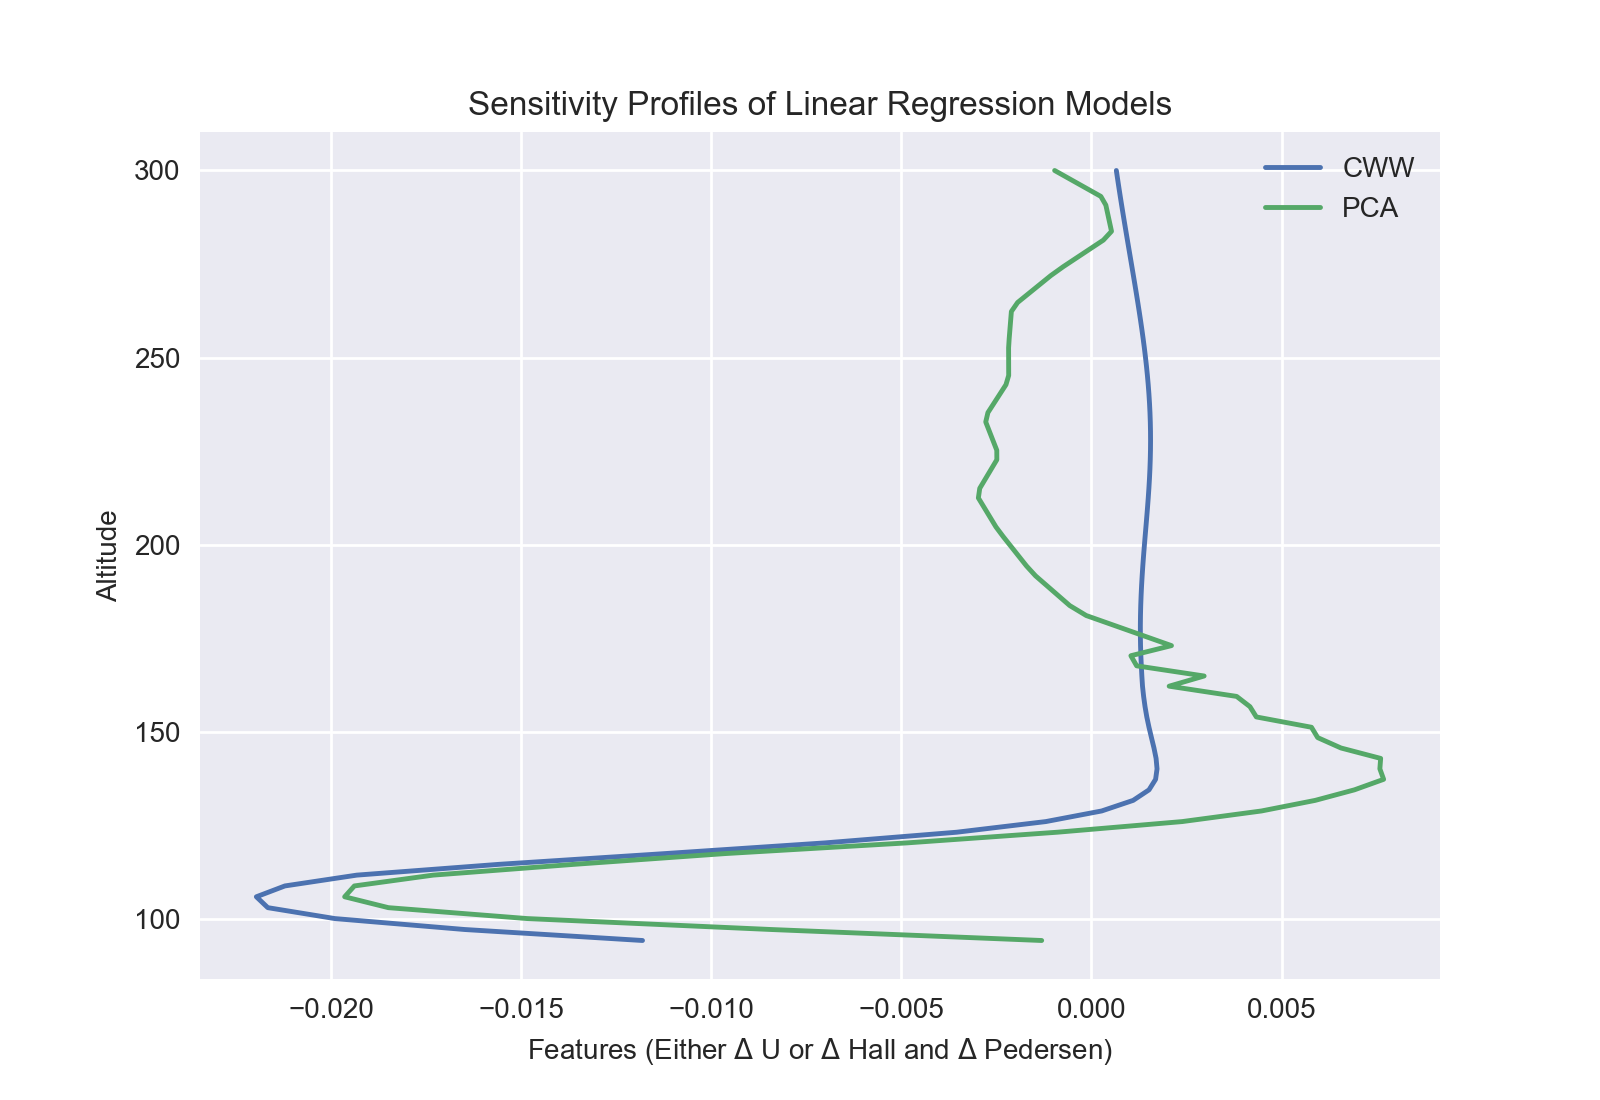

In [14]:
plt.figure()
plt.plot(SP_CCW,d.alt, label = 'CWW')
plt.plot(SP_PCA,d.alt, label = 'PCA')
plt.title('Sensitivity Profiles of Linear Regression Models')
plt.ylabel('Altitude')
plt.xlabel('Features (Either $\Delta$ U or $\Delta$ Hall and $\Delta$ Pedersen)')
plt.legend()
plt.show()